### Modules

In [2]:
import re
from typing import Dict, List, Optional, Text, Tuple
import os
import time
from time import sleep
from tqdm import tqdm_notebook as tqdm
from scipy.ndimage import zoom

import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib.colors import LinearSegmentedColormap
from PIL import Image

import tensorflow as tf
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data import Dataset
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.transforms as transforms
from torch.utils.data import TensorDataset
from torchvision import datasets, models, transforms
import torchvision.models
from torchvision.transforms.functional import F_pil

### Load Data

In [3]:
train_data = torch.load('loaded_training.npy')
val_data = torch.load('loaded_val.npy')
test_data = torch.load('loaded_test.npy')

### Neural Network

In [31]:
class FirePrediction(nn.Module):

    def __init__(self):
        self.name = 'FirePrediction'
        super(FirePrediction, self).__init__()
        self.rnn = nn.GRU(9216, 9216, 1) #512, 256 smaller hidden size
        kernel_size = 4
        stride = 2
        padding = 1
        out_padding = 0
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 182, 3, stride, padding, out_padding),
            nn.ConvTranspose2d(182, 128, 6, stride, padding, out_padding),
            nn.ConvTranspose2d(128, 64, 8, stride, padding, out_padding),
            nn.ConvTranspose2d(64, 32, 9, stride, padding, out_padding),
            nn.ConvTranspose2d(32, 3, 10, stride, padding, out_padding),
        )

    def forward(self, x):
        x = np.array(x)

        if len(x.shape) ==  2:
          print(True)
          x = np.expand_dims(x, axis=1)

        rnn_input = torch.from_numpy(x[0:10, :, :])
        h0 = x[11,:,:]
        h0 = torch.from_numpy(h0[np.newaxis, ...])

        out, h = self.rnn(rnn_input, h0)
    
        output_array = []
    
        for i in range(h.shape[1]):
            decoder_input = h[:,i,:]
            decoder_input = decoder_input[0,:]
            decoder_input = torch.reshape(decoder_input, (256, 6, 6))
            decoder_input = decoder_input[np.newaxis, ...]
            output = self.decoder(decoder_input)
            output = F.relu(output)
            
            if i == 0:
                output_array = output
            else:
                output_array = torch.cat((output_array, output), 0)

        return output_array

### Training

In [34]:
def drop_last(batch_size, data_loader):
    output = data_loader
    counter = -1
    length = len(data_loader)

    if batch_size > len(output):
        batch_size = len(output)

    while len(output) % batch_size != 0:
        
        #print('not the right size, counter at', length)
        output = output[:length]
        length -= 1
        #print('output size', len(output))
        if len(output) % batch_size == 0:
            break
    #print(counter, 'items is neglected')
    

    return output

def concat_batch(batch_size, data_loader):
    batched_set = []
    for i in range(0, len(data_loader), batch_size):
        batched_data = []
        batched_label = []
        for j in range(0, batch_size, 1):
            if j == 0:
                batched_data = data_loader[i][0]
                label = data_loader[i][1]
                label = Image.fromarray(np.array(label))
                #label = label.resize((64, 64))
                label = np.array(label)
                batched_label = label[np.newaxis, ...]
            else:
                batched_data = np.concatenate((batched_data, data_loader[j+i][0]), axis=1)
                label = data_loader[j+i][1]
                label = Image.fromarray(np.array(label))
                #label = label.resize((64, 64))
                label = np.array(label)
                batched_label = np.concatenate((batched_label, label[np.newaxis, ...]), axis=0)
            #print('batch data shape', batched_data.shape)
            #print('batch label shape', batched_label.shape)
            if i+j == len(data_loader)-1:
                break
        batched_set.append((batched_data, batched_label))
        
    return batched_set

def get_accuracy(model, data_loader, use_cuda=True):
    accuracies = []
    counter = 0
    
    for features, labels in tqdm(data_loader, desc='Accuracy', unit='batch'):
        recon = model(features)
        recon = torch.transpose(recon, 1, 2) #give 0 3 1 3
        recon = torch.transpose(recon, 2, 3) # give 0 2 3 1
        difference = np.array(recon.detach().numpy()) - np.array(labels)
        squared_difference = np.square(difference)
        mse = np.mean(squared_difference)/(255**2)
        accuracies.append(mse)
        counter += 1
        
    sigma = 0
    for item in accuracies:
        sigma += item
        #print('sigma is', sigma, 'number of error calculated is', counter, 'the average is', float(sigma)/float(counter))

    acc_sum = float(sigma)
    item_num = int(counter)

    number = (acc_sum, item_num)

    return number[1]/number[0]

def get_model_name(name, learning_rate, epoch):
    path = "model_{0}_lr{1}_epoch{2}".format(name, learning_rate, epoch)
    return path

def get_val_loss(model, valid_loader, criterion, use_cuda=True):
    total_val_loss = 0.0
    i = 0

    for data,label in tqdm(valid_loader, desc='Loss', unit='batch'):
        label = torch.from_numpy(label)
        '''
        #############################################
        # To Enable GPU Usage
        if use_cuda and torch.cuda.is_available():
          data = data.cuda()
          label = label.cuda()
        #############################################
        '''

        recon = model(data)

        #0 1 2 3
        recon = torch.transpose(recon, 1, 2) #give 0 3 1 3
        recon = torch.transpose(recon, 2, 3) # give 0 2 3 1
        '''
        recon = torch.from_numpy(recon).detach()
        label = torch.from_numpy(label).detach()
        '''
        loss = criterion(recon, label.float())
        #loss.requires_grad=True
        total_val_loss += loss.item()
        i += 1
    val_loss = float(total_val_loss)/i
    return val_loss

def train(model, train_loader, valid_loader, batch_size=90, num_epochs=5, learning_rate=1e-4, use_cuda=True):
    """ Training loop. You should update this."""
    torch.manual_seed(42)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)

    train_err = np.zeros(num_epochs)
    train_loss = np.zeros(num_epochs)
    val_err = np.zeros(num_epochs)
    val_loss = np.zeros(num_epochs)

    print('Loading dataset into batch_size of', batch_size)
    train_loader = drop_last(batch_size, train_loader)
    train_loader = concat_batch(batch_size, train_loader)
    valid_loader = drop_last(batch_size, valid_loader)
    valid_loader = concat_batch(batch_size, valid_loader)

    start_time = time.time()
    for epoch in tqdm(range(num_epochs), desc='Epoch', unit='epoch'):
        total_train_loss = 0.0
        i = 0
        for data,label in tqdm(train_loader, desc='Training', unit='batch'):
            label = torch.from_numpy(label)

            '''
            #############################################
            # To Enable GPU Usage
            if use_cuda and torch.cuda.is_available():
                data = data.cuda()
                label = label.cuda()
            #############################################
            '''
            recon = model(data)

            #0 1 2 3
            recon = torch.transpose(recon, 1, 2) #give 0 3 1 3
            recon = torch.transpose(recon, 2, 3) # give 0 2 3 1
            '''
            recon = torch.from_numpy(recon).detach()
            label = torch.from_numpy(label).detach()
            '''
            optimizer.zero_grad()
            #print('recon size', recon.size)
            #print('label size', label.size, 'label type is', type(label))
            loss = criterion(recon, label.float())
            #loss.requires_grad=True
            total_train_loss += loss.item()
            i += 1
            loss.backward()
            optimizer.step()
            
        print('Calculating epoch', epoch, 'training error')
        train_err[epoch] = get_accuracy(model, train_loader)
        
        print('Calculating epoch', epoch, 'training loss')
        train_loss[epoch] = float(total_train_loss)/(i + 1)
        #print('The shape of train_loader[1][0]:', train_loader[1][0].shape)
        #print('The shape of valid_loader[1][0]:', valid_loader[1][0].shape)
        
        print('Calculating epoch', epoch, 'validation error')
        val_err[epoch] = get_accuracy(model, valid_loader)
        
        print('Calculating epoch', epoch, 'validation loss')
        val_loss[epoch] = get_val_loss(model, valid_loader, criterion)
        print(("Epoch {}: Train acc: {}, Train loss: {} |"+
               "Validation acc: {}, Validation loss: {}").format(
                   epoch + 1,
                   train_err[epoch],
                   train_loss[epoch],
                   val_err[epoch],
                   val_loss[epoch]))
        # Save the current model (checkpoint) to a file
        if (epoch + 1) % 100 == 0:
            model_path = get_model_name(model.name, learning_rate, epoch)
            torch.save(model.state_dict(), model_path)
    print('Finished Training')
    end_time = time.time()
    elapsed_time = end_time - start_time
    print("Total time elapsed: {:.2f} seconds".format(elapsed_time))

    # Plotting
    plt.title("Train vs Validation Loss")
    plt.plot(range(1 ,num_epochs+1), train_loss, label="Train")
    plt.plot(range(1 ,num_epochs+1), val_loss, label="Validation")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend(loc='best')
    plt.show()

    plt.title("Train vs Validation Accuracy")
    plt.plot(range(1 ,num_epochs+1), train_err, label="Train")
    plt.plot(range(1 ,num_epochs+1), val_err, label="Validation")
    plt.xlabel("Epochs")
    plt.ylabel("Training Accuracy")
    plt.legend(loc='best')
    plt.show()

    print("Final Training Accuracy: {}".format(train_err[-1]))
    print("Final Validation Accuracy: {}".format(val_err[-1]))

Loading dataset into batch_size of 32


C:\Users\harry\AppData\Local\Temp\ipykernel_12472\740349727.py:129: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for epoch in tqdm(range(num_epochs), desc='Epoch', unit='epoch'):


Epoch:   0%|          | 0/1 [00:00<?, ?epoch/s]

C:\Users\harry\AppData\Local\Temp\ipykernel_12472\740349727.py:132: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for data,label in tqdm(train_loader, desc='Training', unit='batch'):


Training:   0%|          | 0/12 [00:00<?, ?batch/s]

Calculating epoch 0 training error


C:\Users\harry\AppData\Local\Temp\ipykernel_12472\740349727.py:54: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for features, labels in tqdm(data_loader, desc='Accuracy', unit='batch'):


Accuracy:   0%|          | 0/12 [00:00<?, ?batch/s]

Calculating epoch 0 training loss
Calculating epoch 0 validation error


Accuracy:   0%|          | 0/2 [00:00<?, ?batch/s]

Calculating epoch 0 validation loss


C:\Users\harry\AppData\Local\Temp\ipykernel_12472\740349727.py:84: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for data,label in tqdm(valid_loader, desc='Loss', unit='batch'):


Loss:   0%|          | 0/2 [00:00<?, ?batch/s]

Epoch 1: Train acc: 30.846325360357667, Train loss: 1970.2610720120942 |Validation acc: 21.652018517942686, Validation loss: 3003.18408203125
Finished Training
Total time elapsed: 192.08 seconds


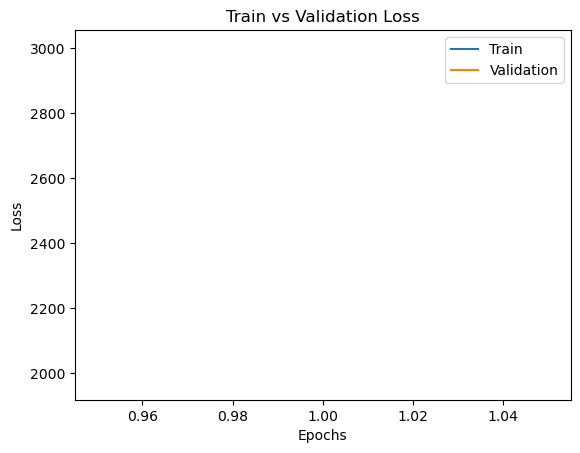

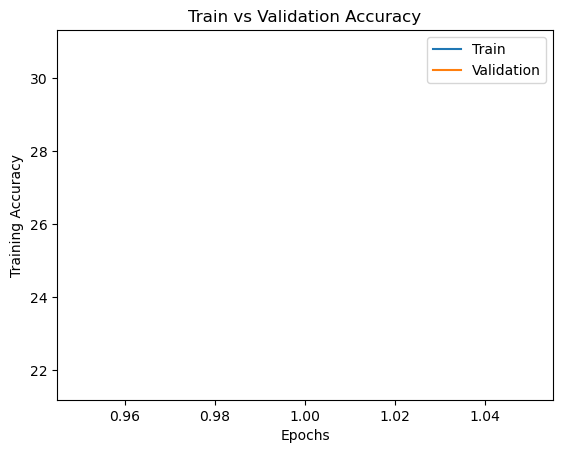

Final Training Accuracy: 30.846325360357667
Final Validation Accuracy: 21.652018517942686


In [35]:
model_2 = FirePrediction()
train(model_2, train_data, val_data, num_epochs=1, batch_size = 32)

In [30]:
def image_viewer(image_array):
    if len(image_array.shape) == 4:
        image_array = image_array[0,:,:,:]
        image_array = np.array(image_array.detach().numpy())
        image_array = np.transpose(image_array, (1, 2, 0))
    elif len(image_array.shape) == 3:
        image_array = np.array(image_array.detach().numpy())
        #image_array = np.transpose(image_array, (0, =))
    else:
        raise Typererror('Incorrect dimension')
        
    plt.imshow(image_array)
    plt.show()
    return

-----0th testing data-----


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


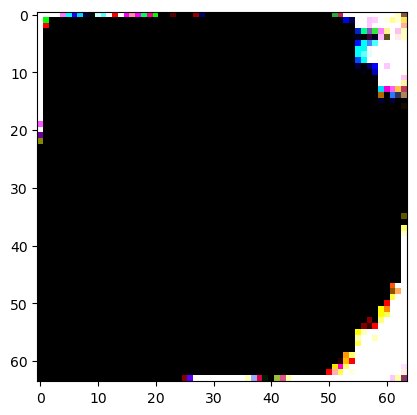

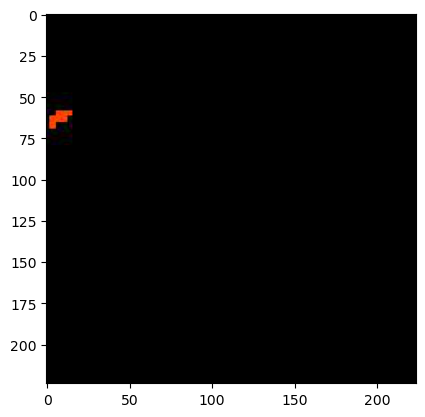

-----1th testing data-----


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


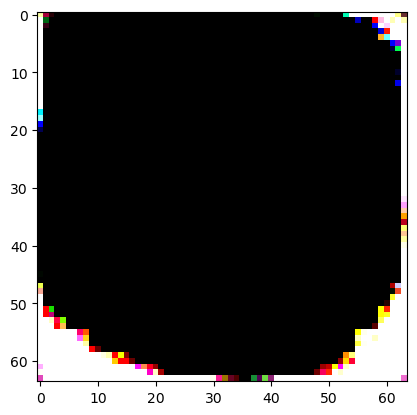

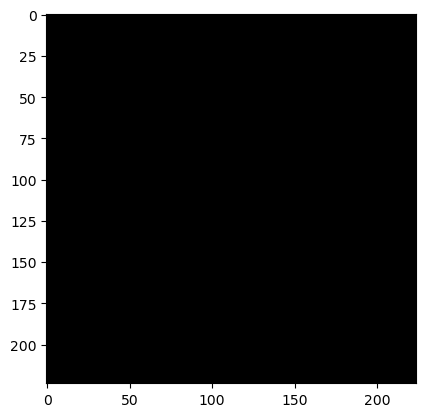

-----2th testing data-----


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


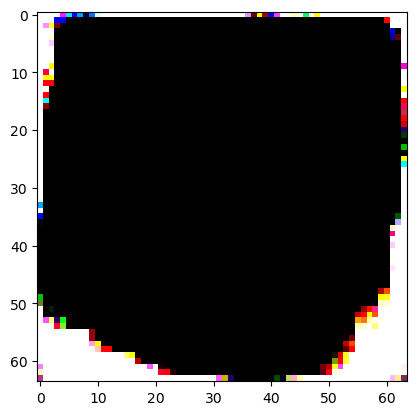

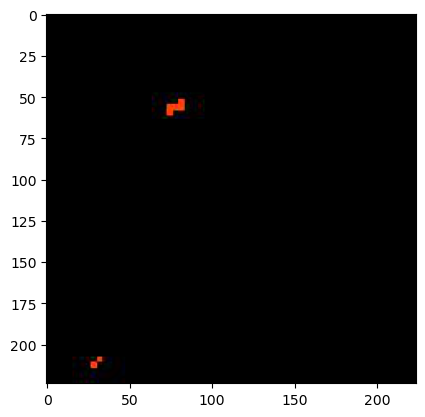

-----3th testing data-----


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


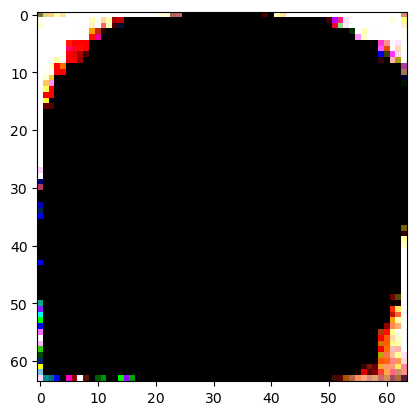

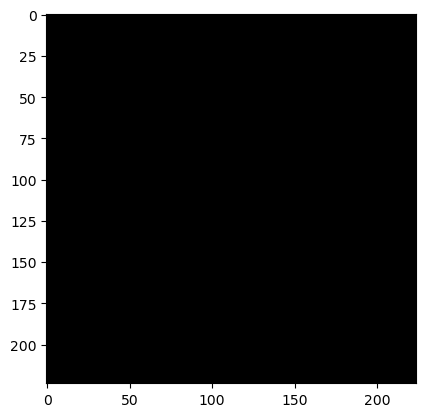

-----4th testing data-----


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


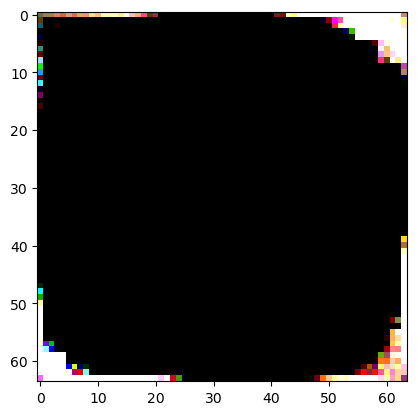

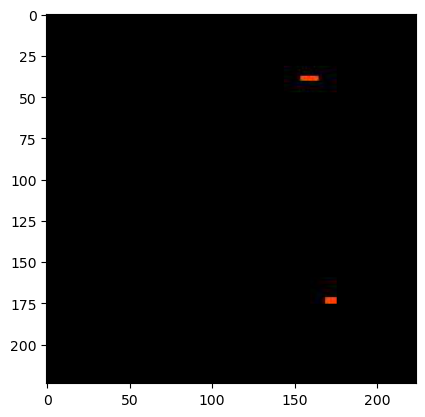

-----5th testing data-----


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


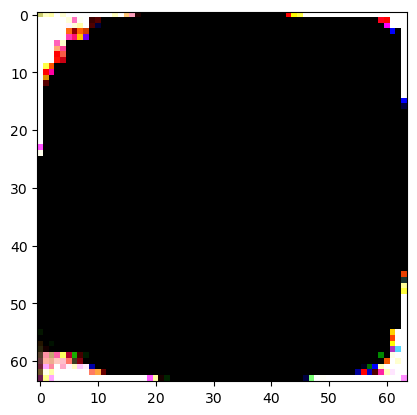

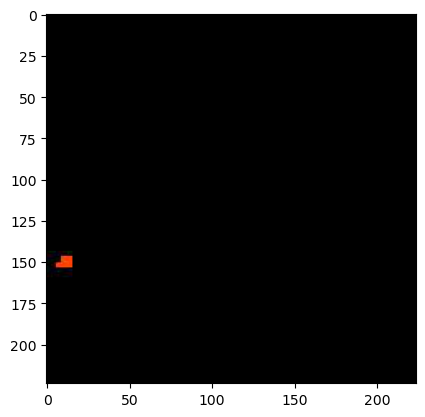

-----6th testing data-----


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


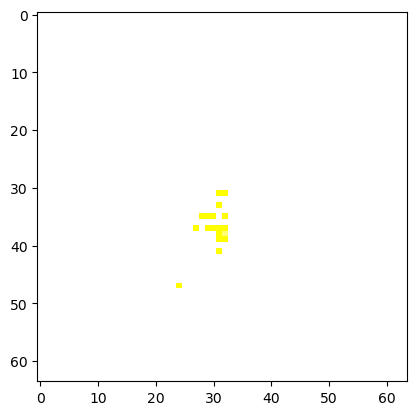

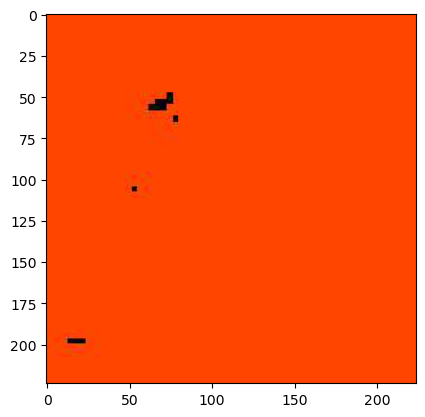

-----7th testing data-----


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


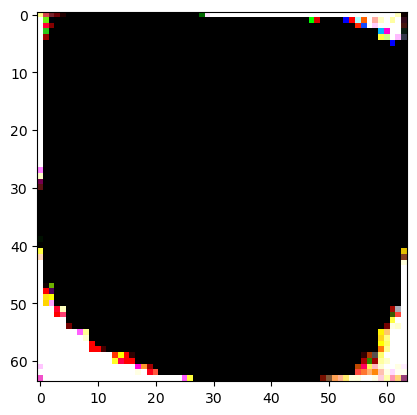

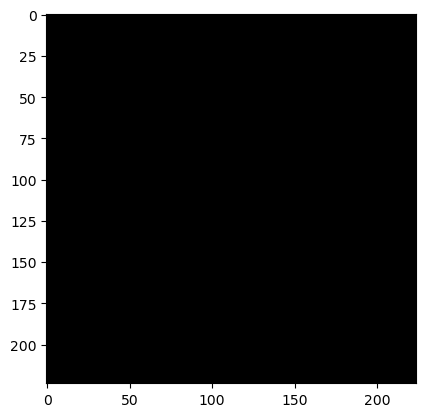

-----8th testing data-----


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


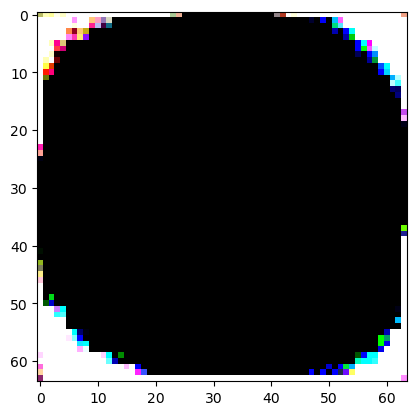

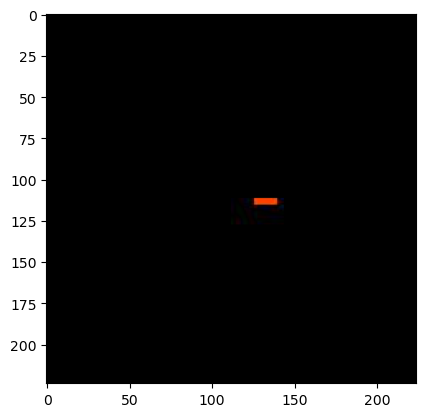

-----9th testing data-----


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


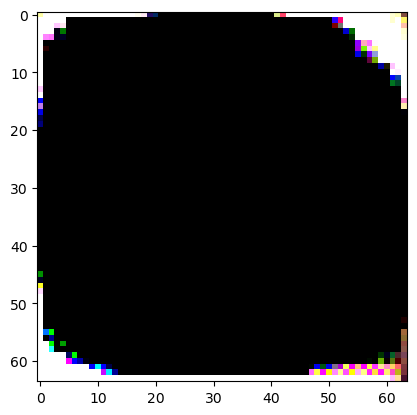

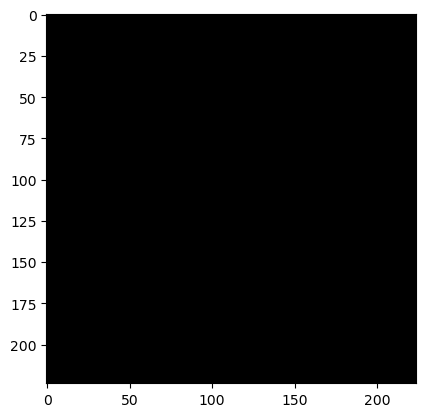

-----10th testing data-----


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


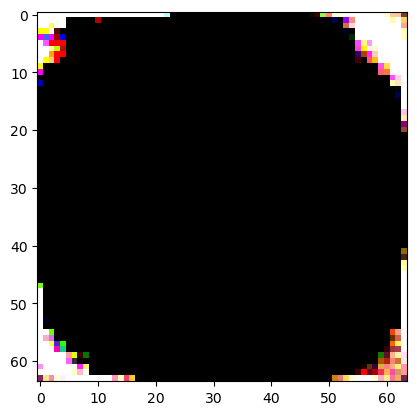

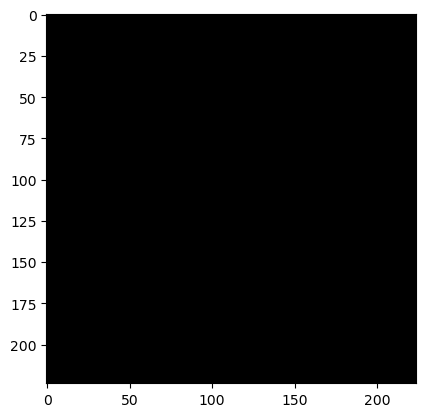

-----11th testing data-----


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


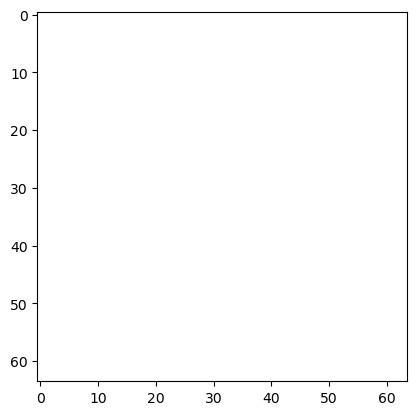

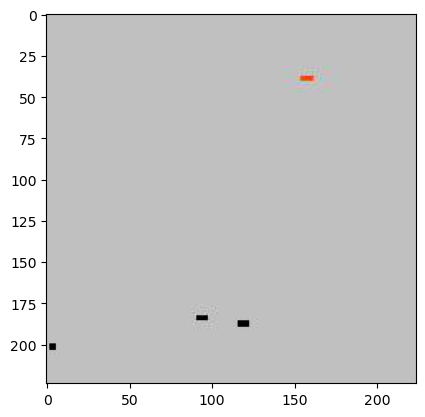

-----12th testing data-----


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


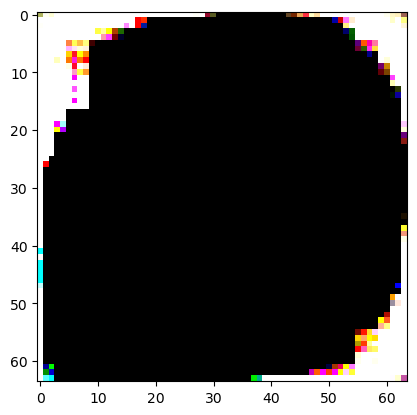

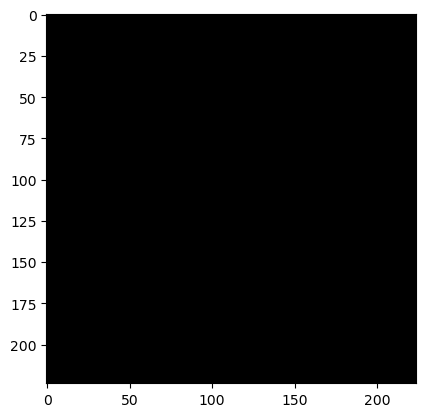

-----13th testing data-----


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


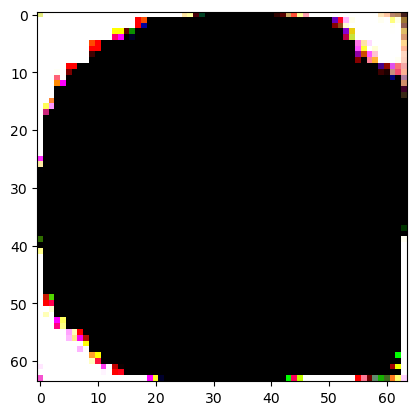

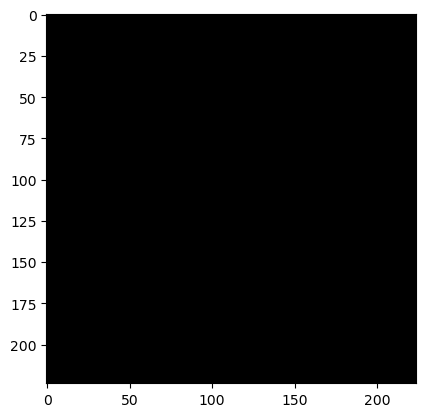

-----14th testing data-----


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


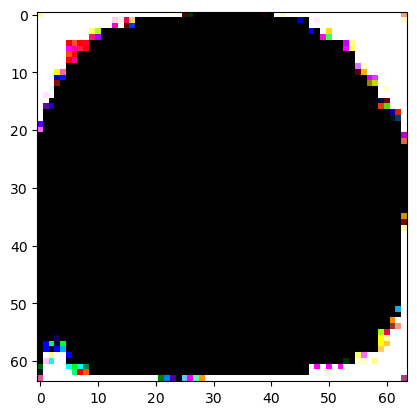

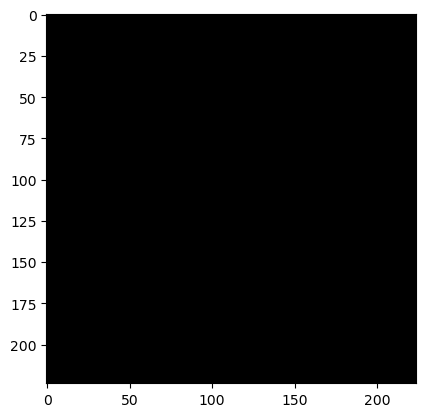

-----15th testing data-----


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


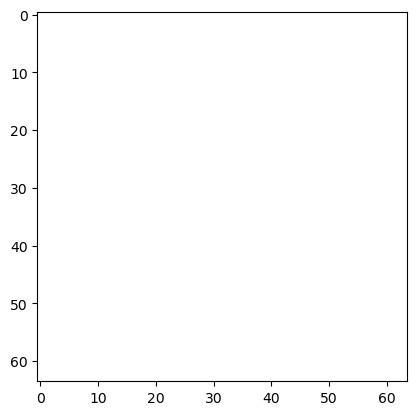

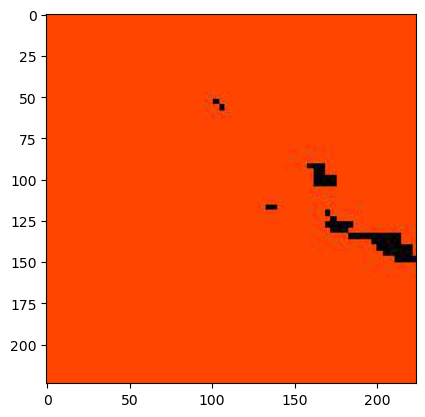

-----16th testing data-----


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


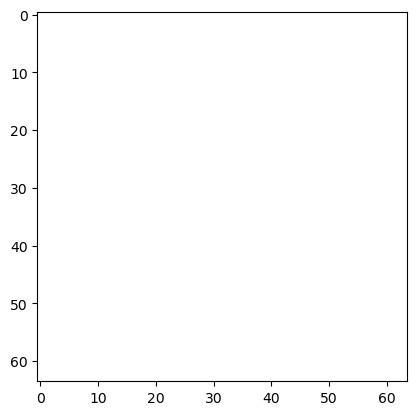

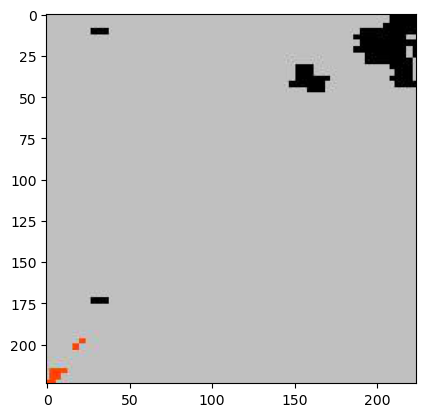

-----17th testing data-----


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


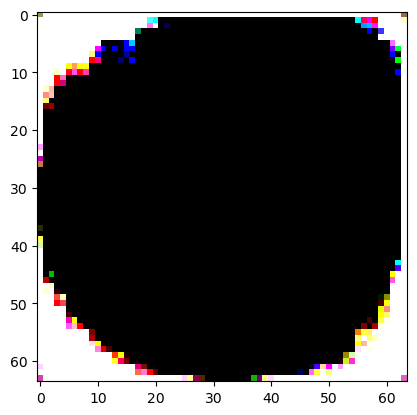

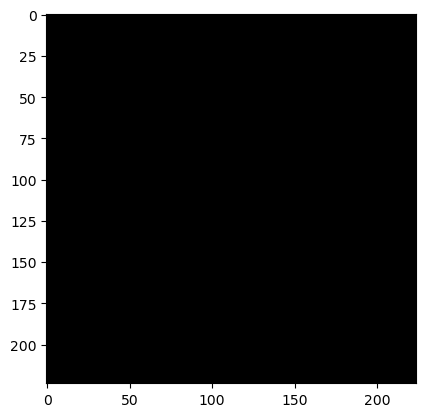

-----18th testing data-----


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


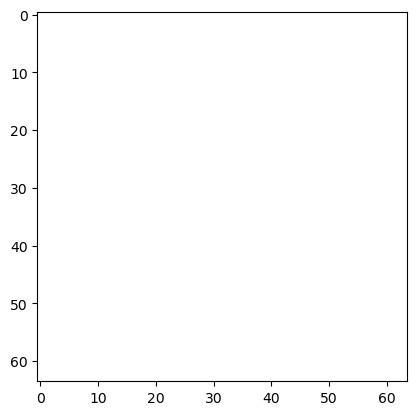

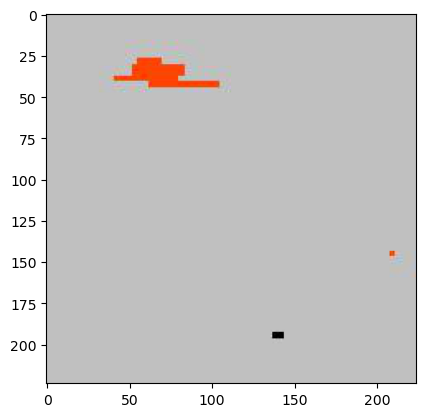

-----19th testing data-----


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


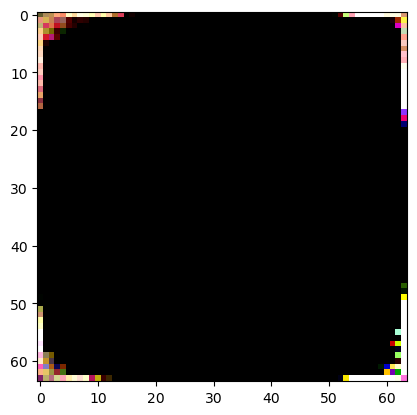

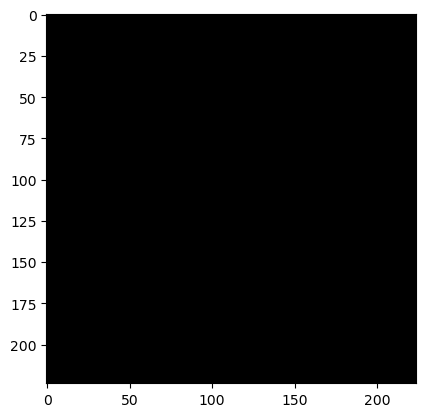

-----20th testing data-----


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


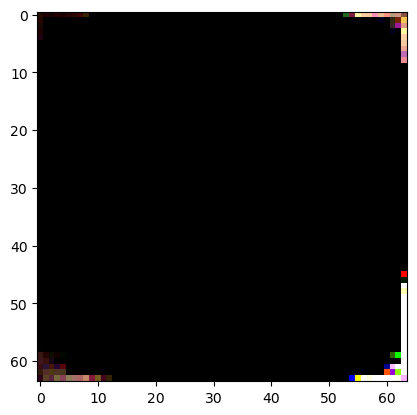

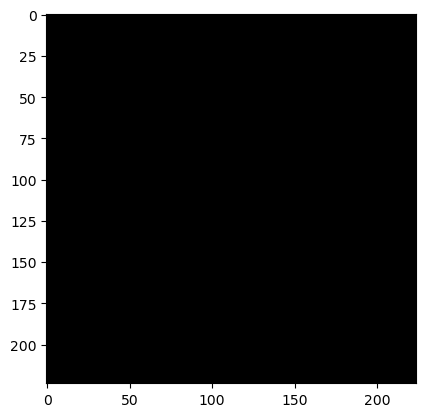

-----21th testing data-----


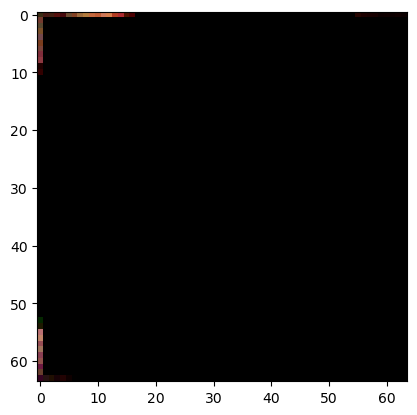

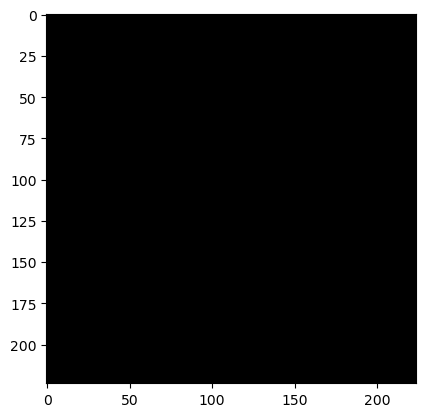

-----22th testing data-----


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


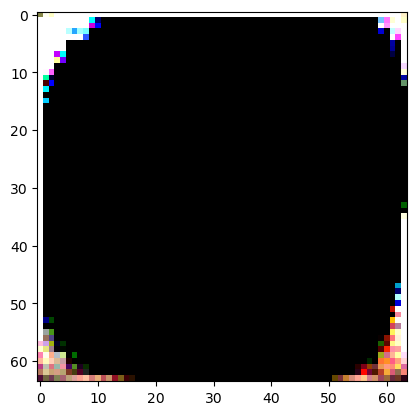

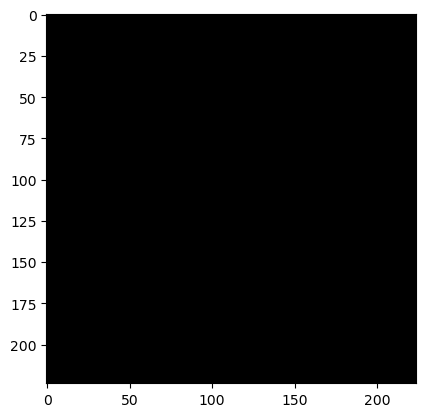

-----23th testing data-----


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


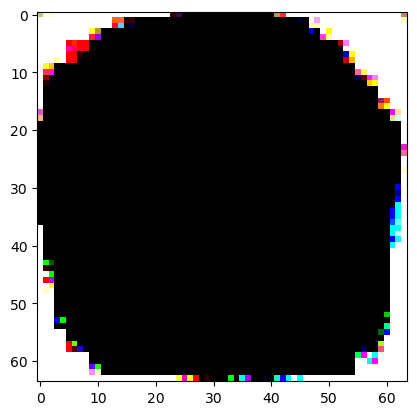

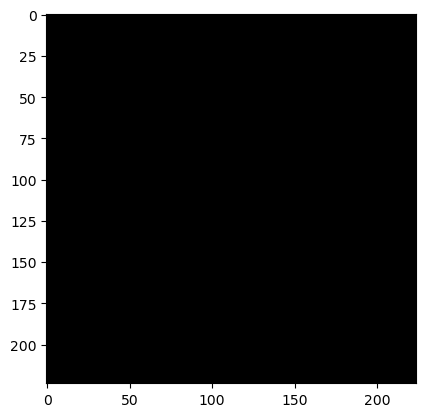

-----24th testing data-----


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


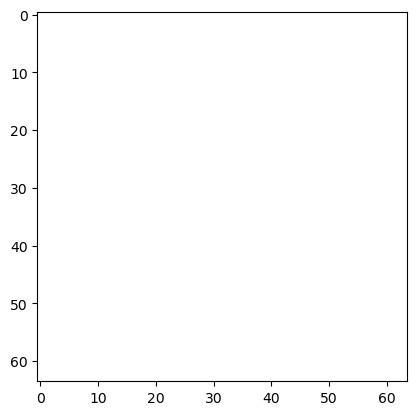

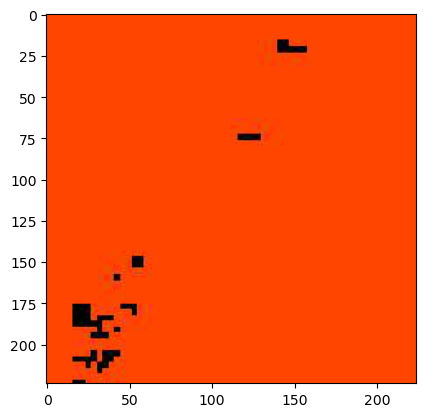

-----25th testing data-----


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


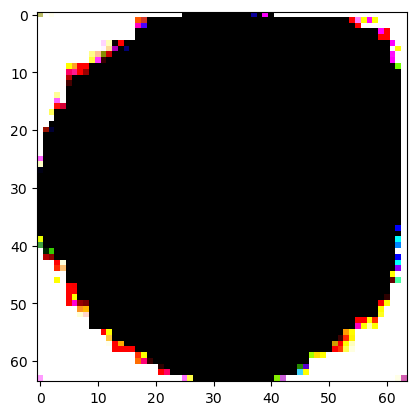

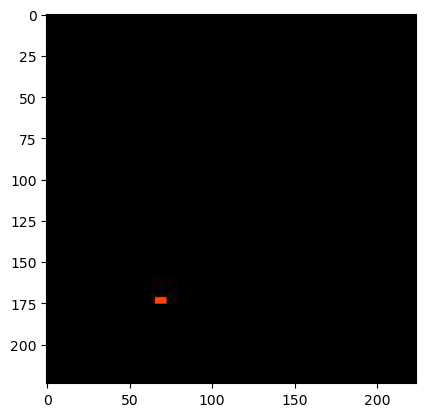

-----26th testing data-----


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


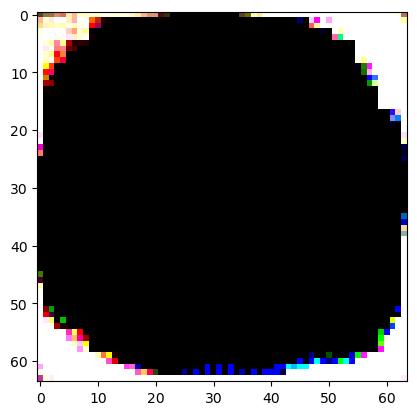

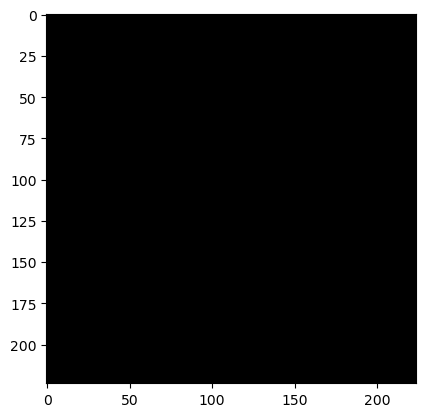

-----27th testing data-----


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


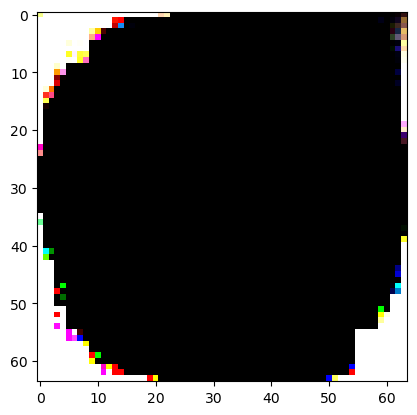

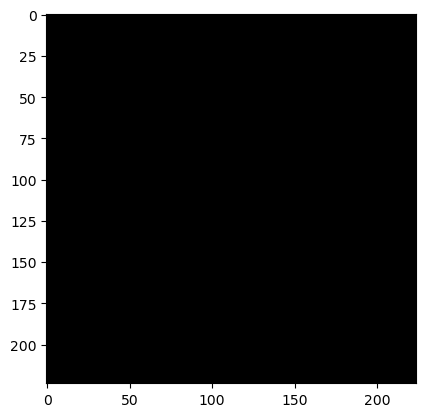

-----28th testing data-----


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


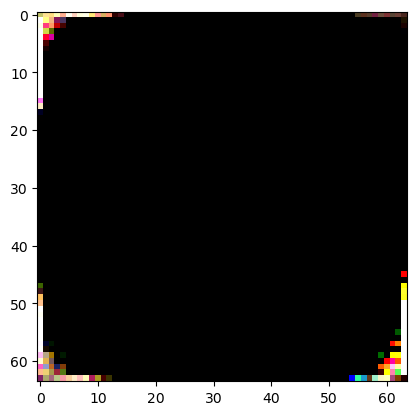

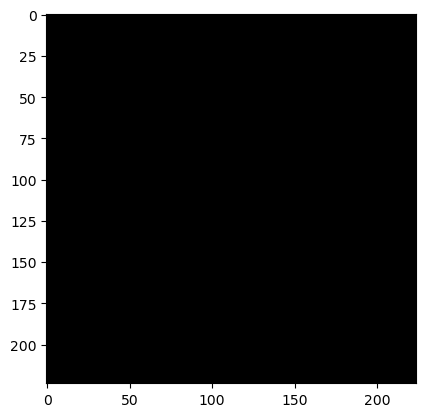

-----29th testing data-----


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


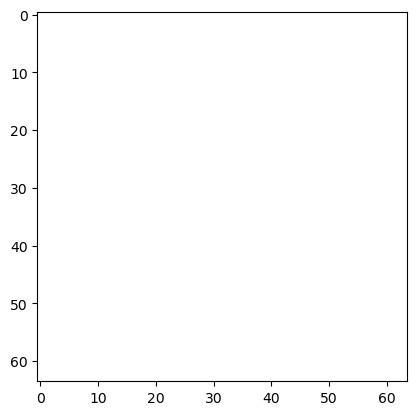

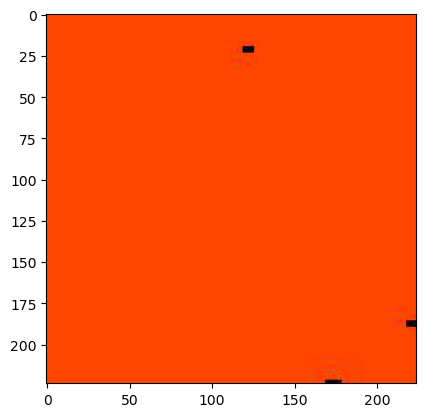

-----30th testing data-----


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


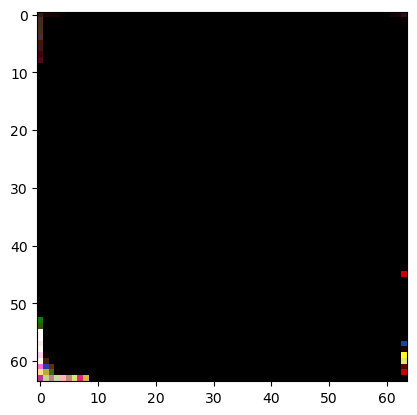

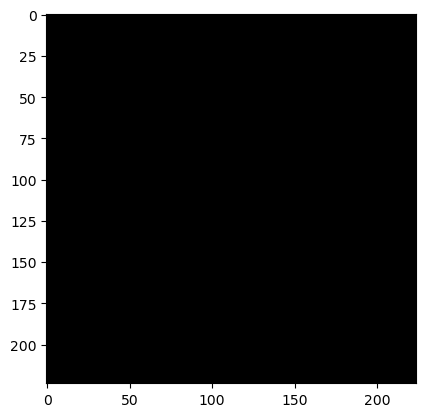

-----31th testing data-----


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


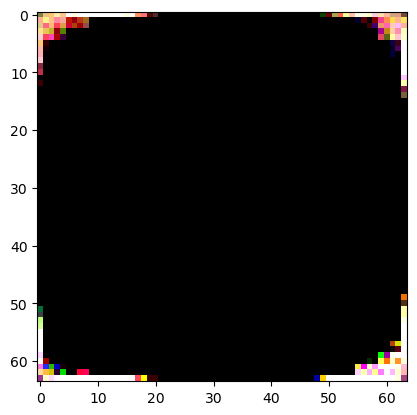

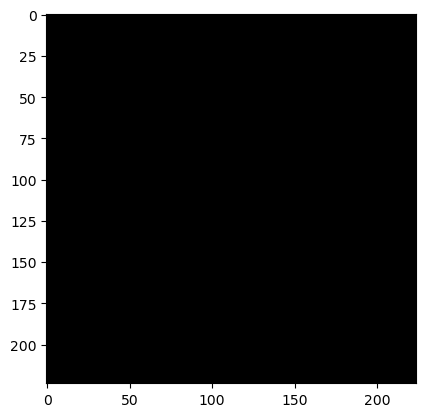

-----32th testing data-----


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


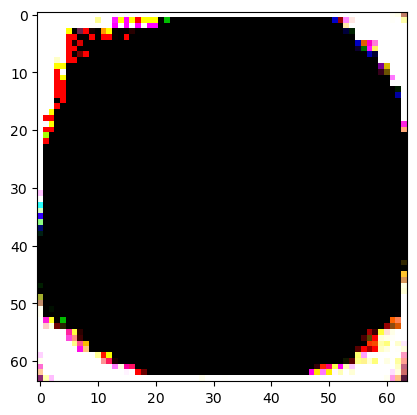

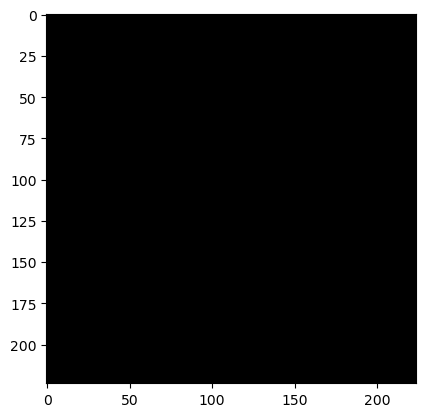

-----33th testing data-----


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


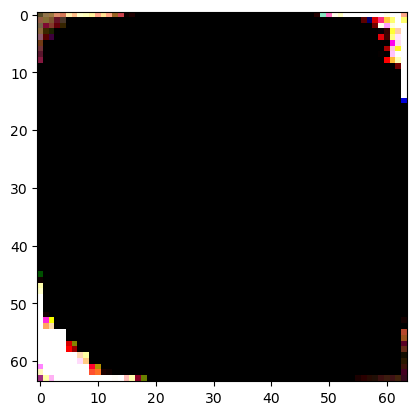

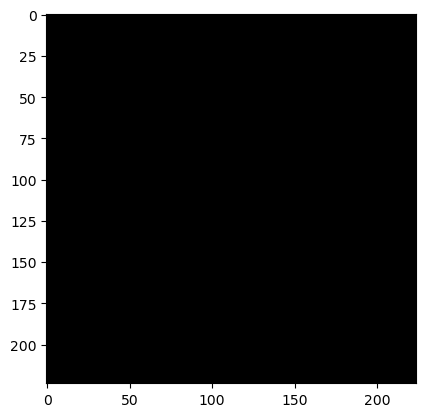

-----34th testing data-----


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


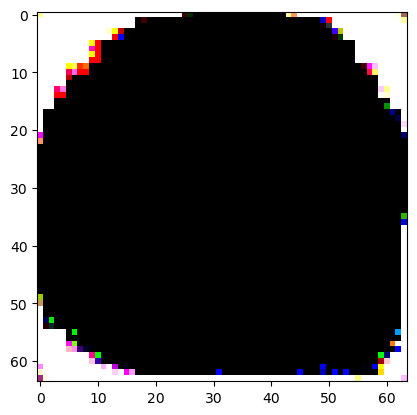

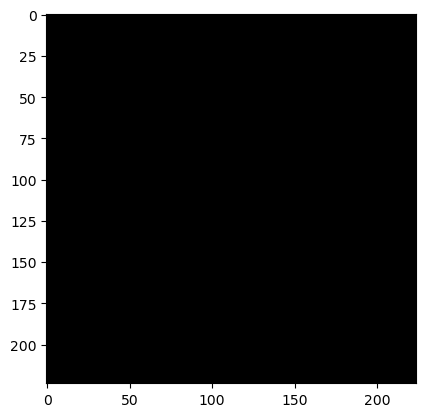

-----35th testing data-----


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


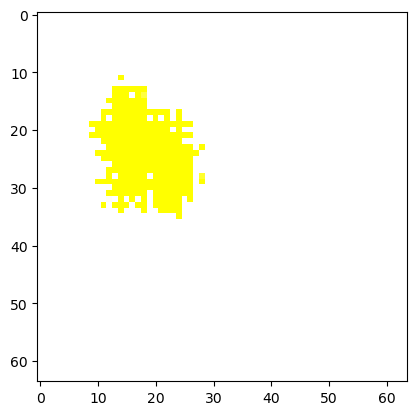

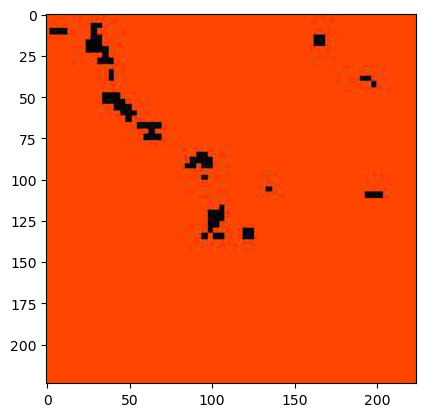

-----36th testing data-----


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


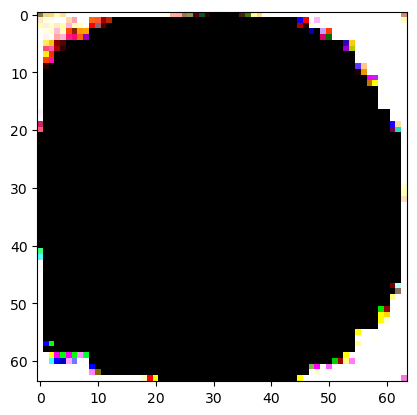

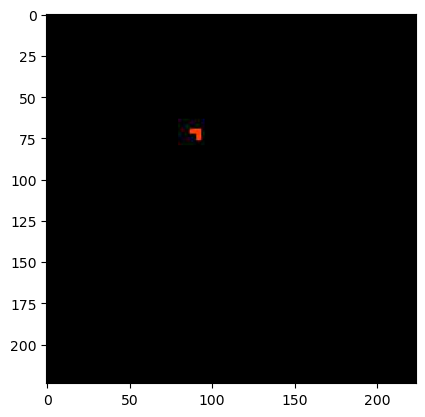

-----37th testing data-----


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


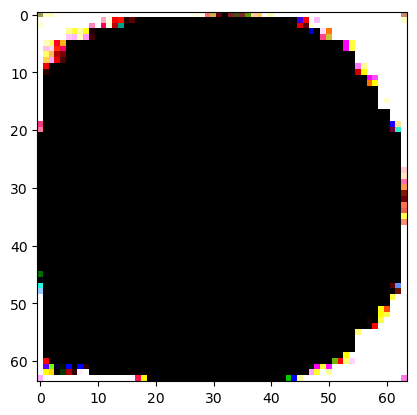

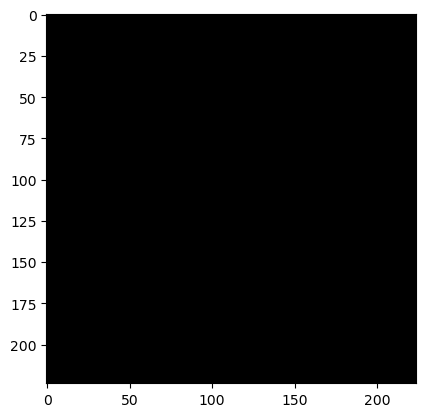

-----38th testing data-----


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


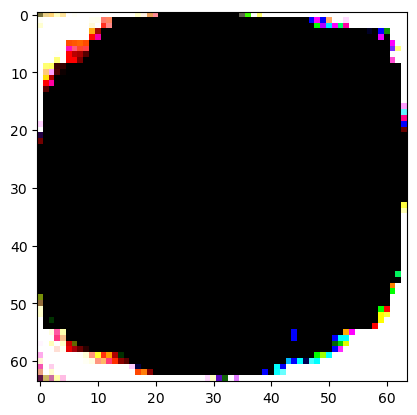

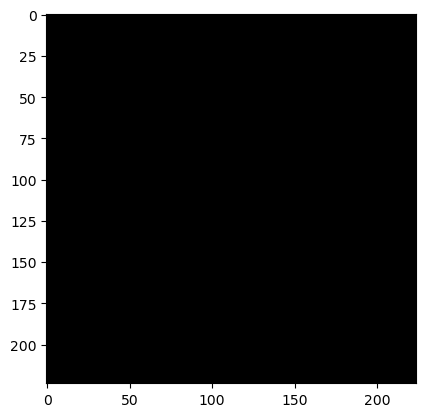

-----39th testing data-----


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


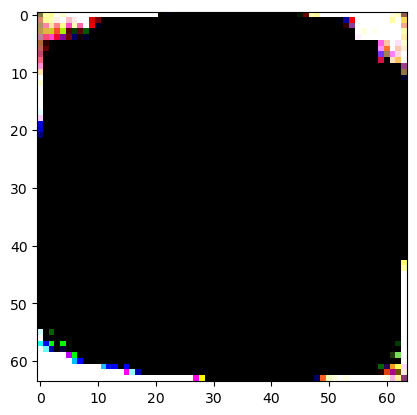

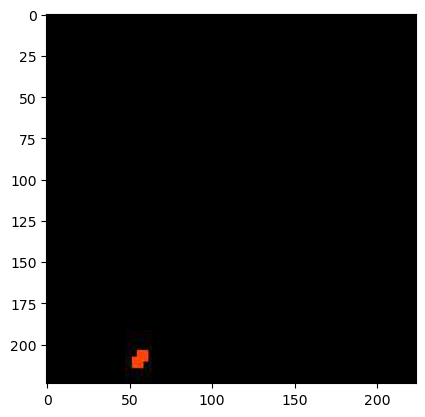

-----40th testing data-----


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


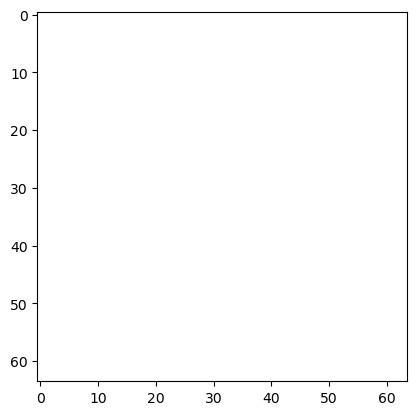

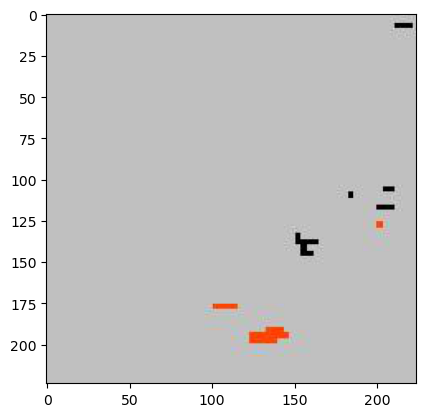

-----41th testing data-----


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


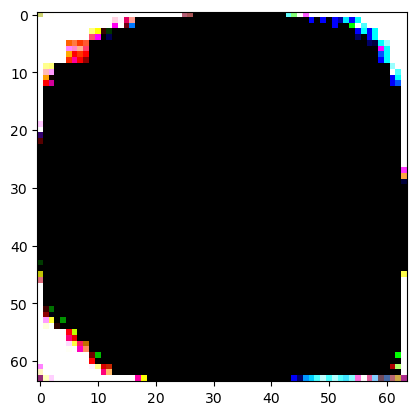

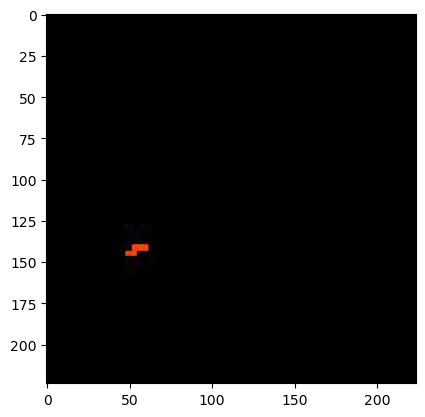

-----42th testing data-----


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


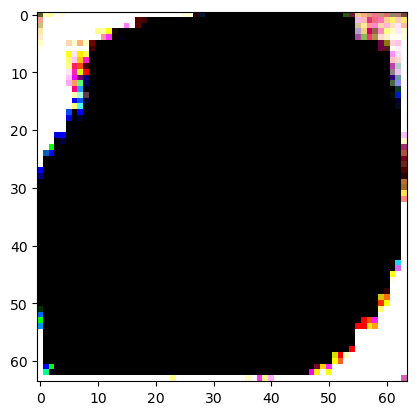

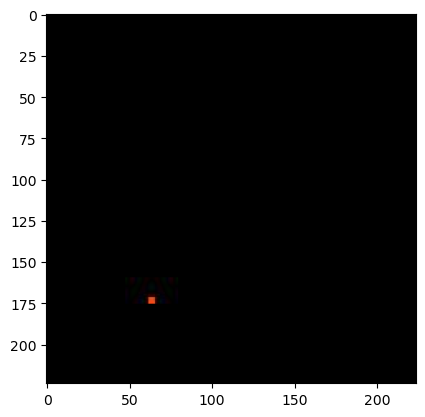

-----43th testing data-----


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


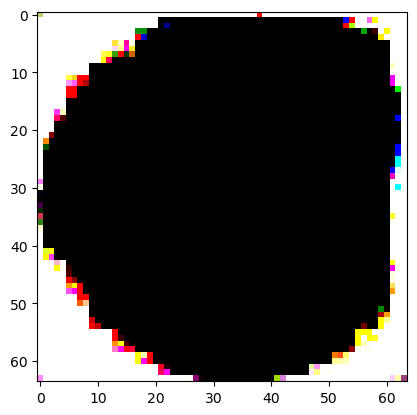

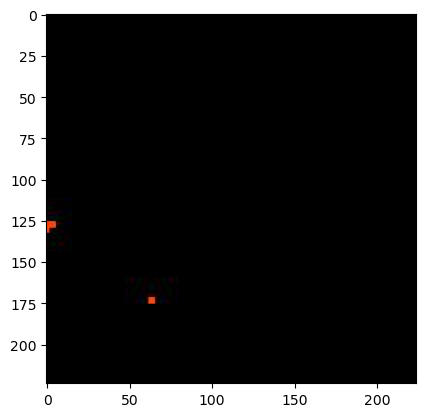

-----44th testing data-----


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


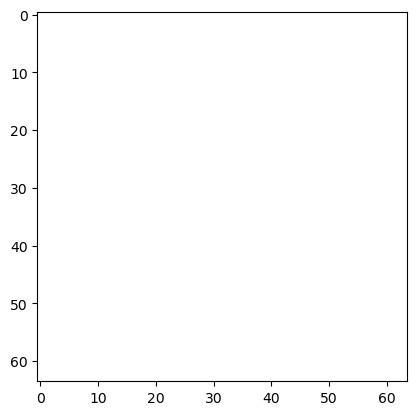

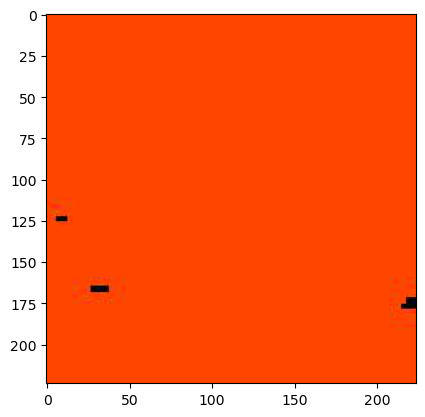

-----45th testing data-----


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


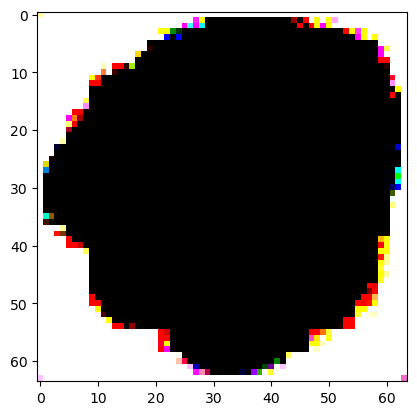

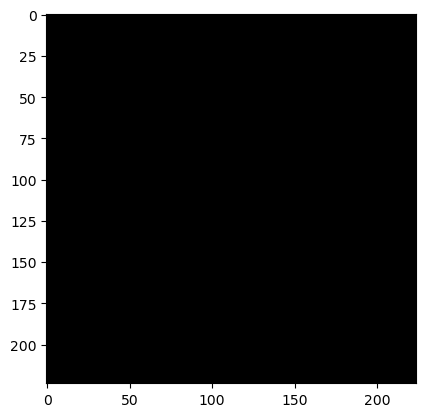

-----46th testing data-----


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


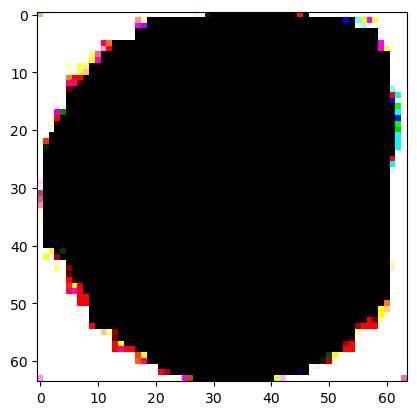

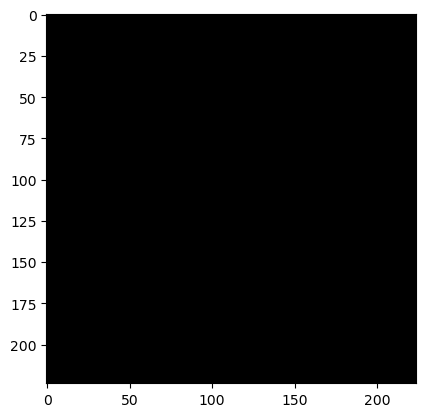

-----47th testing data-----


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


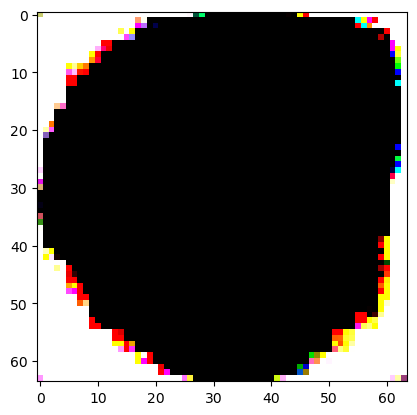

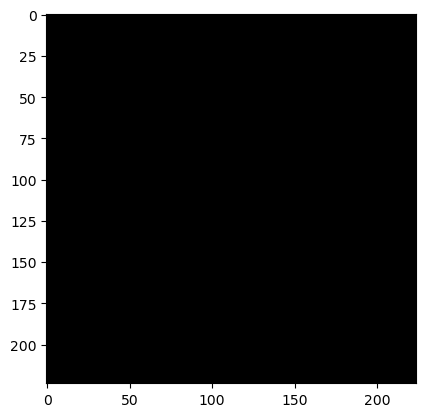

-----48th testing data-----


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


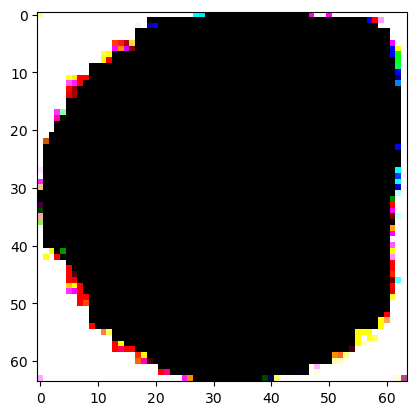

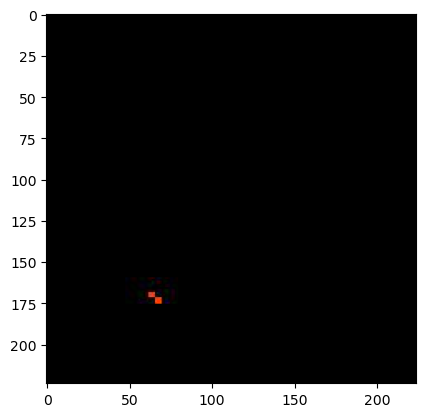

-----49th testing data-----


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


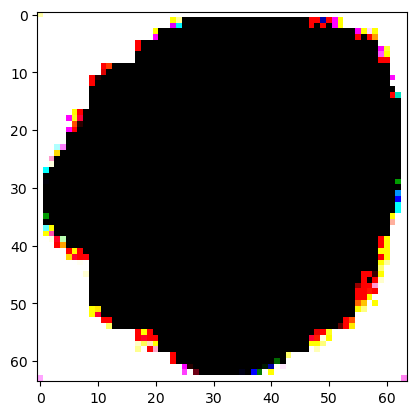

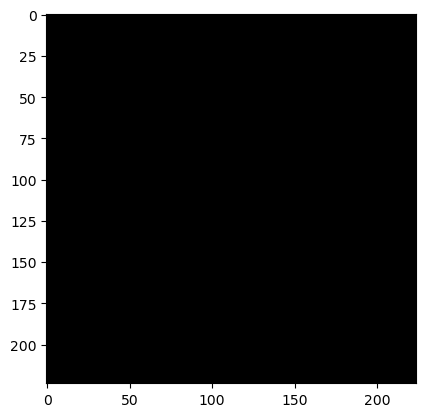

-----50th testing data-----


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


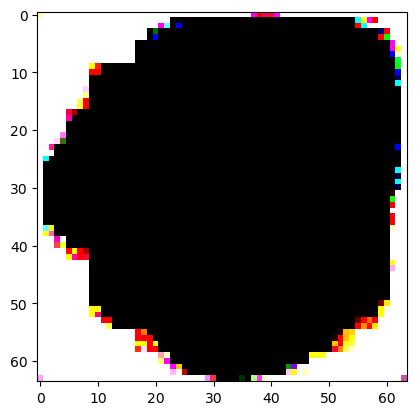

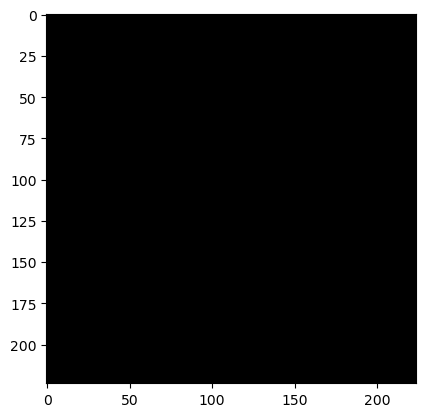

-----51th testing data-----


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


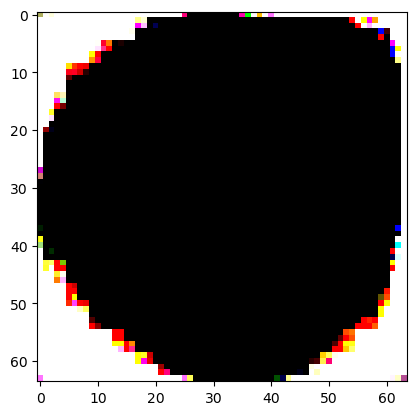

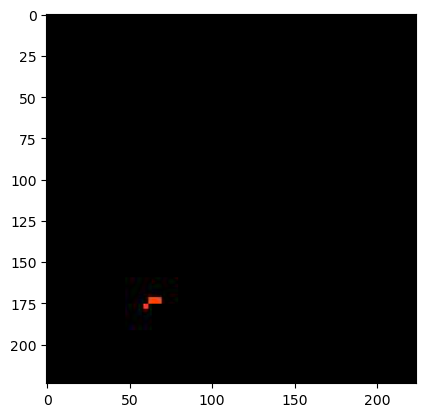

-----52th testing data-----


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


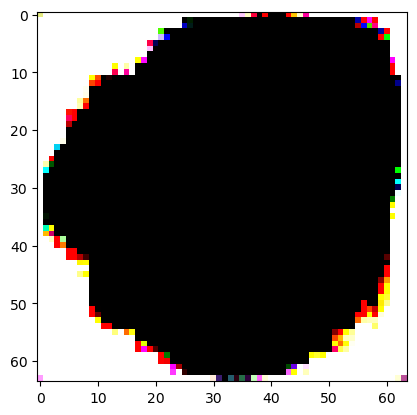

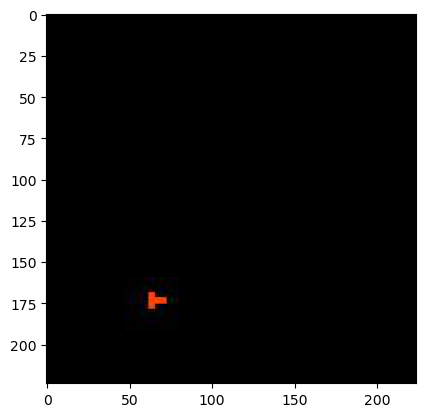

-----53th testing data-----


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


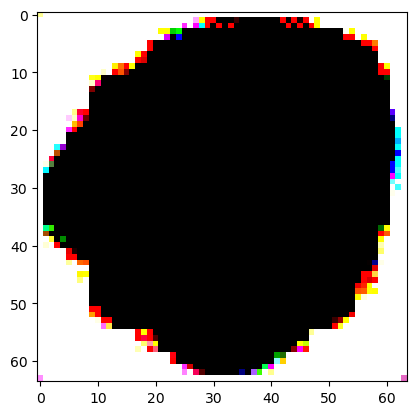

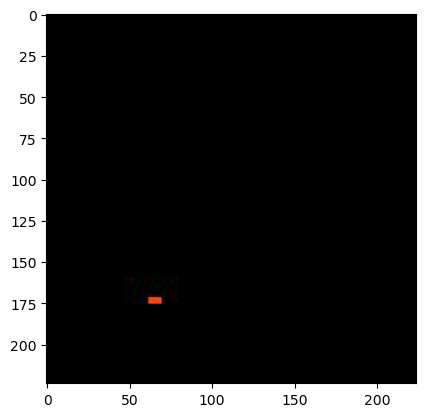

-----54th testing data-----


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


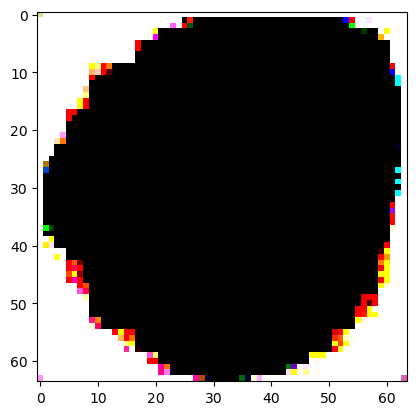

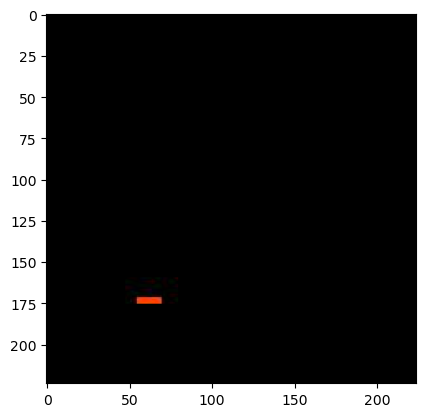

-----55th testing data-----


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


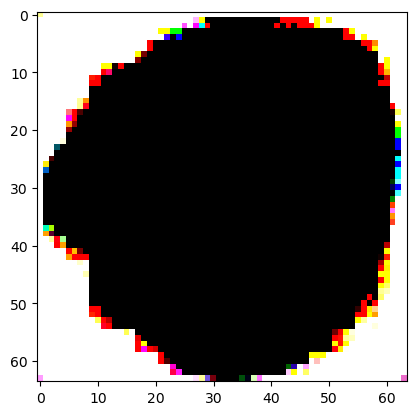

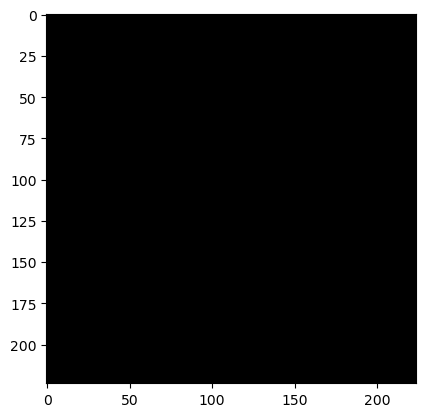

-----56th testing data-----


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


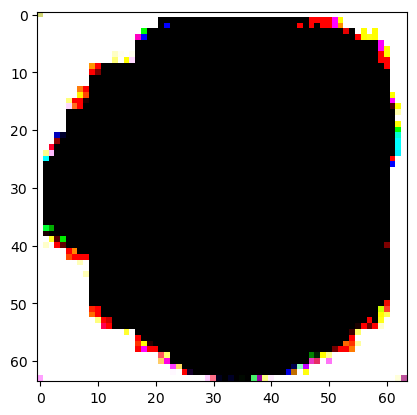

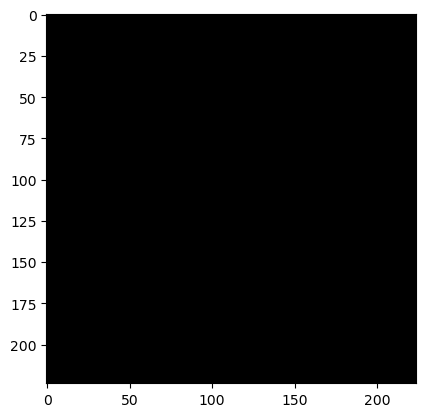

-----57th testing data-----


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


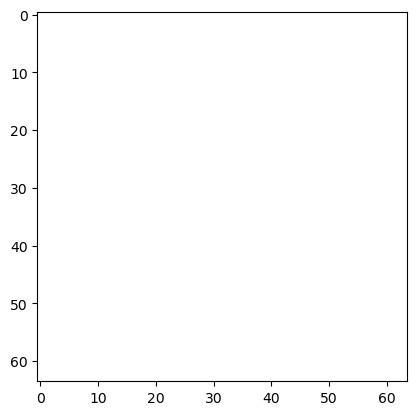

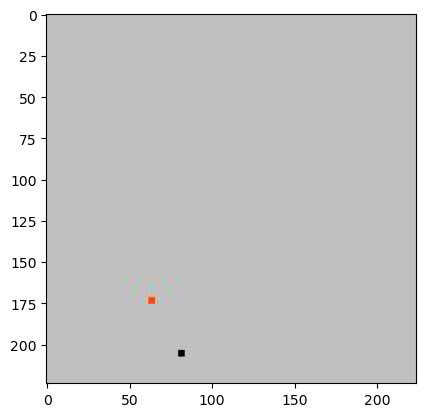

-----58th testing data-----


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


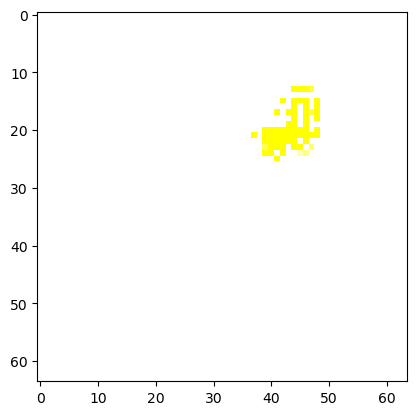

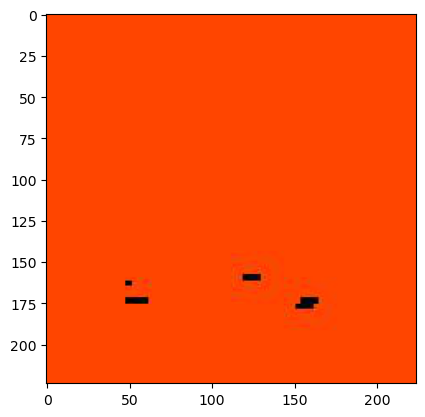

-----59th testing data-----


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


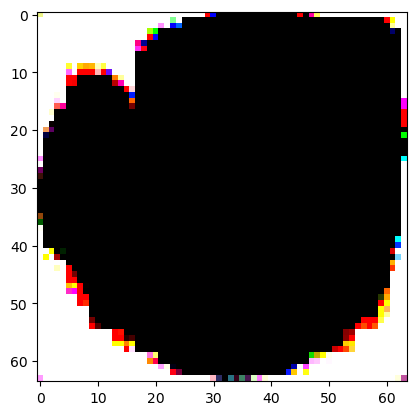

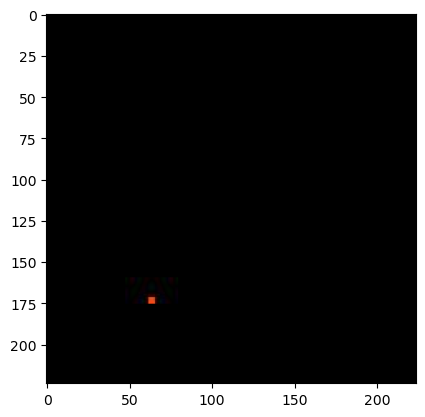

-----60th testing data-----


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


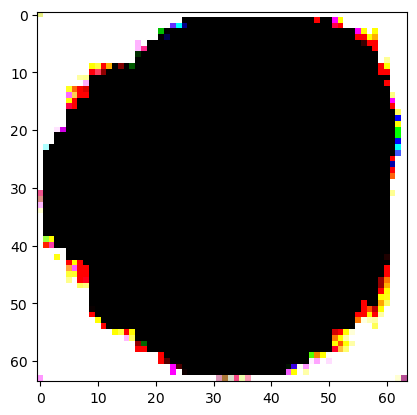

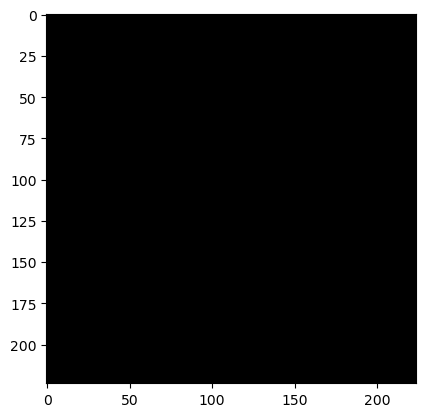

-----61th testing data-----


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


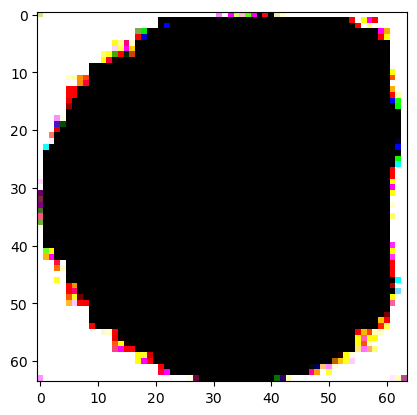

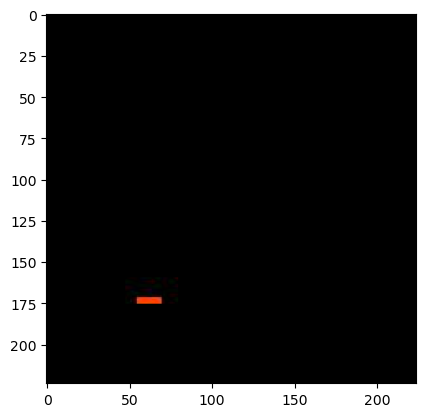

-----62th testing data-----


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


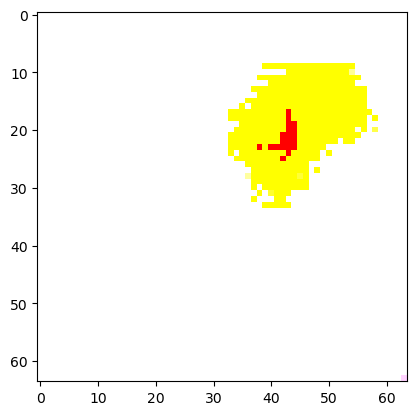

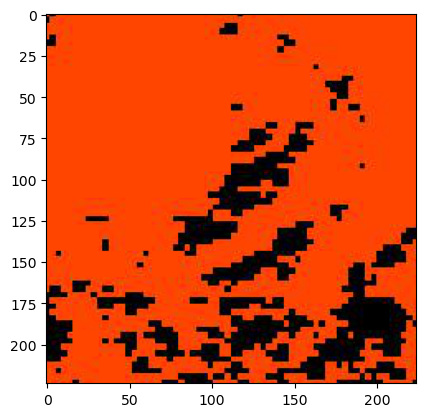

-----63th testing data-----


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


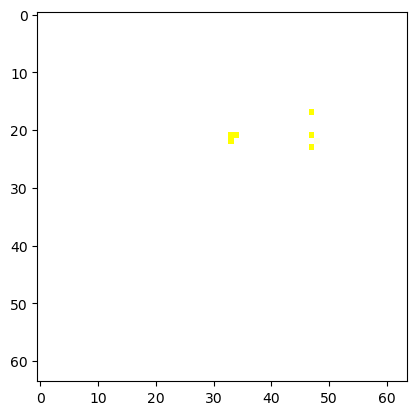

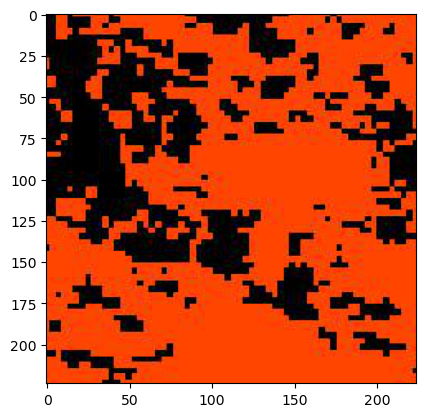

-----64th testing data-----


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


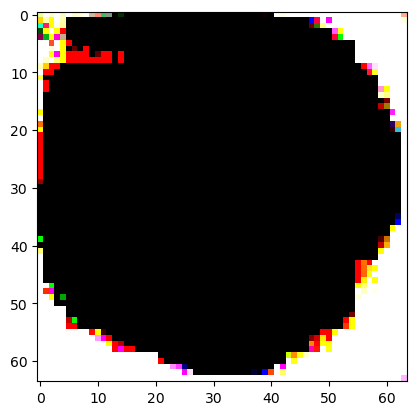

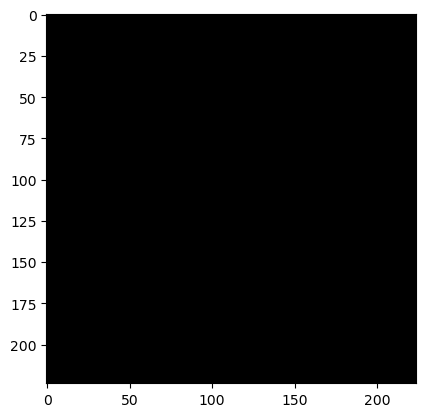

-----65th testing data-----


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


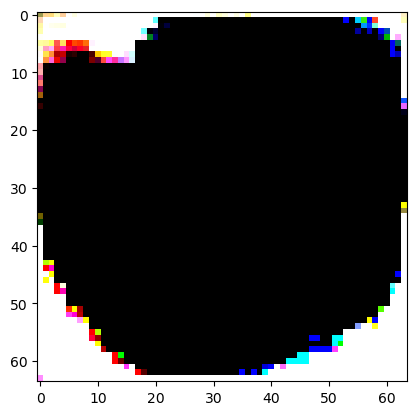

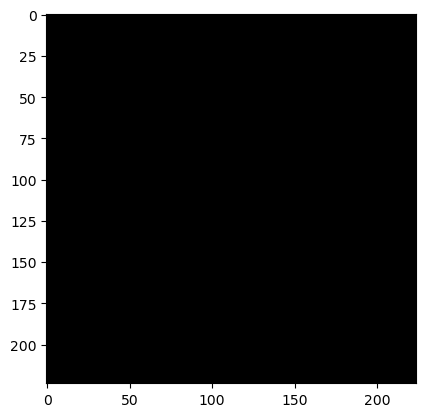

-----66th testing data-----


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


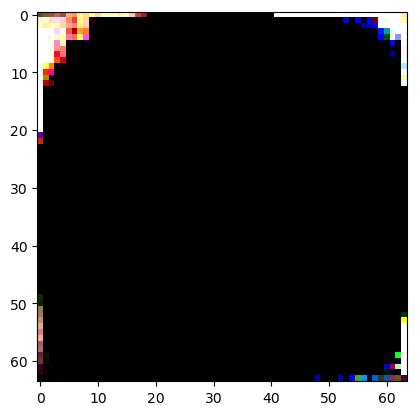

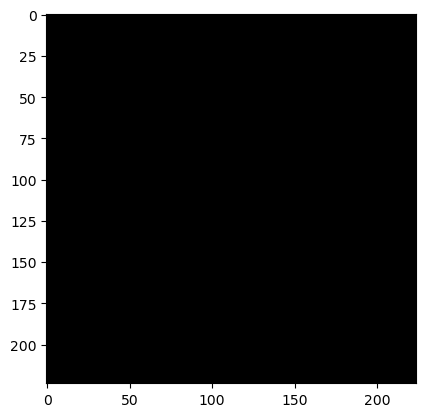

-----67th testing data-----


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


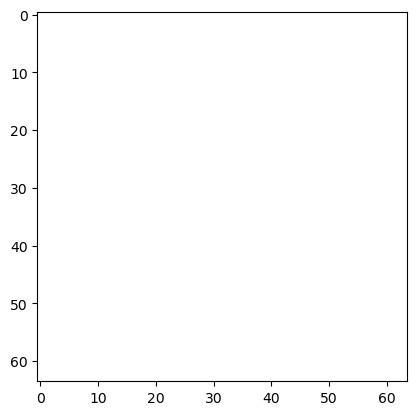

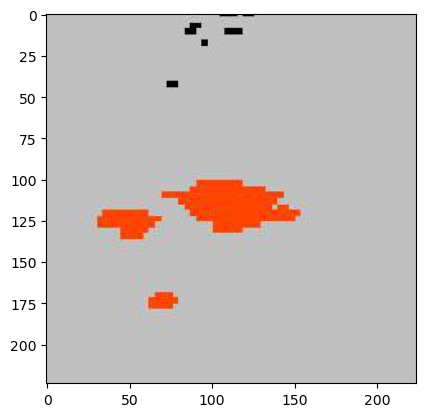

-----68th testing data-----


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


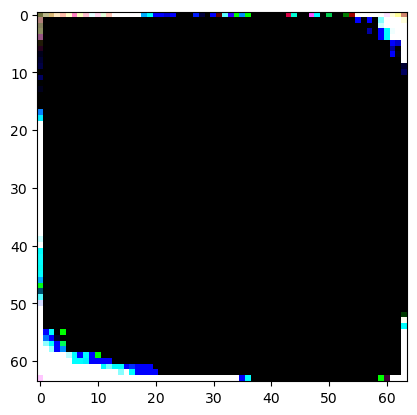

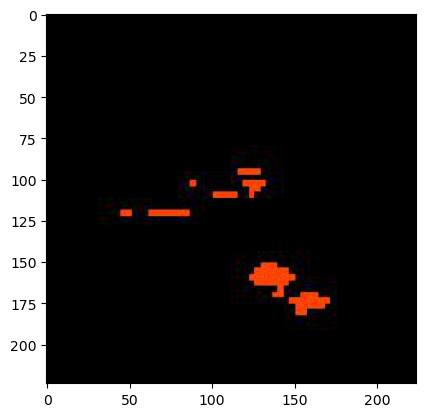

-----69th testing data-----


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


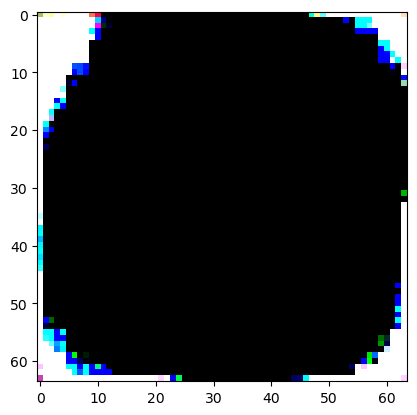

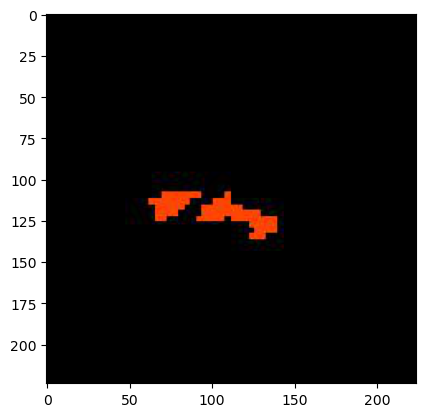

-----70th testing data-----


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


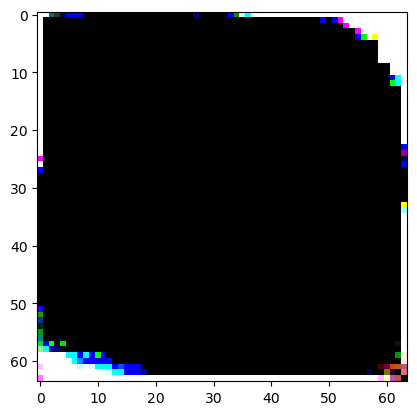

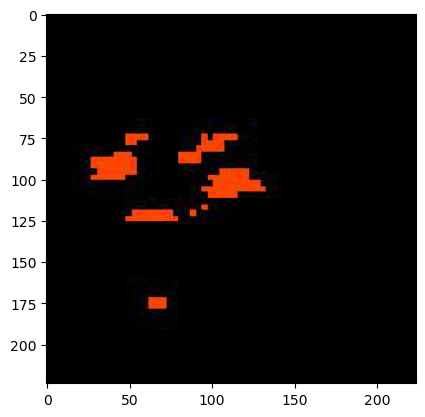

-----71th testing data-----


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


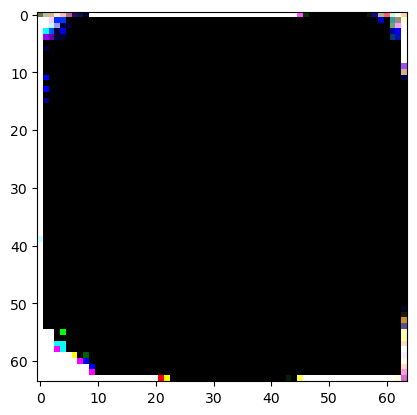

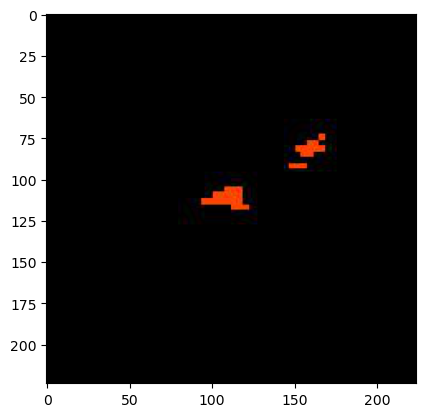

-----72th testing data-----


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


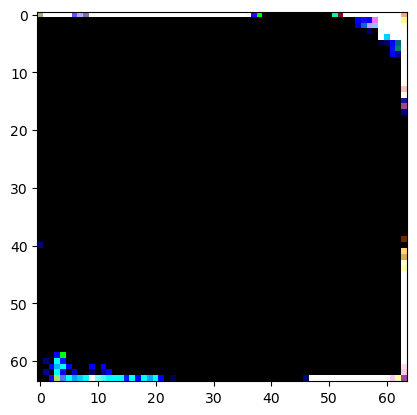

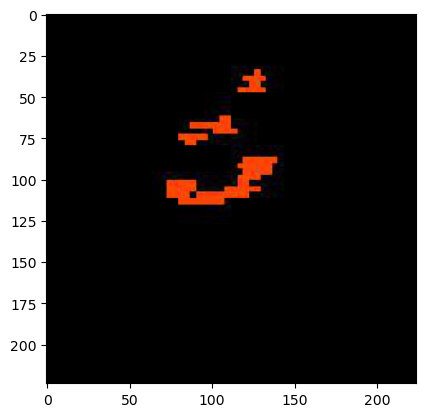

-----73th testing data-----


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


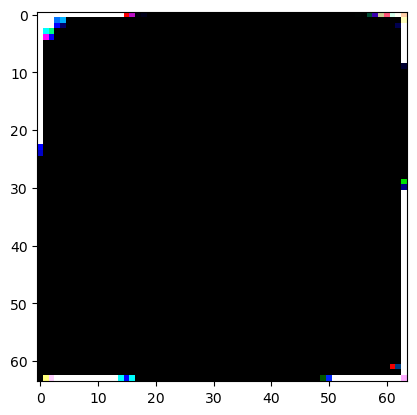

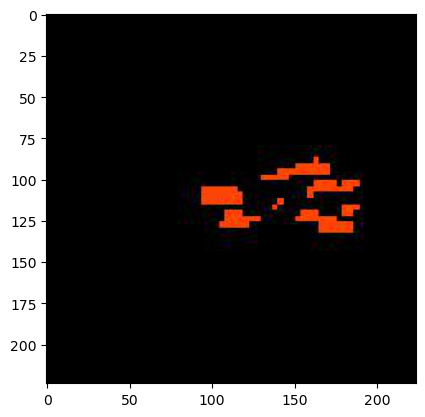

In [55]:
for i in range(len(test_data)):
    print('-----' + str(i) +'th testing data' + '-----')
    output = model(test_data[i][0])
    label = test_data[i][1]
    image_viewer(output)
    image_viewer(label)
    if i > len(test_data):
        break